# Summary of DAS

This notebook contains a list of Python methods that were introduced in the DAS programming exercises.

### Import the libraries

In [1]:
import numpy as np  # import auxiliary library, typical idiom
import pandas as pd  # import the Pandas library, typical idiom

from statsmodels.distributions.empirical_distribution import ECDF

from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # set Seaborn defaults
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

# <span class="section">1.</span> Filtering


In [2]:
df_nasdaq = pd.read_csv('../datasets/NASDAQ.csv', parse_dates=[0])
df_nasdaq = df_nasdaq.set_index('Date')[['Close']]
df_nasdaq.columns = ['close']

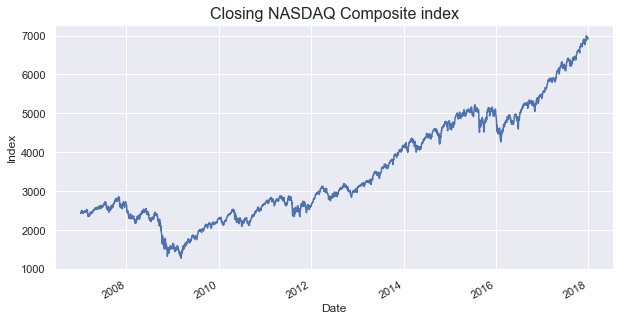

In [3]:
ax = df_nasdaq['close'].plot()
ax.set_ylabel('Index')
ax.set_title('Closing NASDAQ Composite index',fontsize=16);

## Gaussian filter


In [4]:
df_nasdaq['close_filtered'] = gaussian_filter1d(df_nasdaq['close'], sigma=30, mode='nearest')

Text(0, 0.5, 'Index')

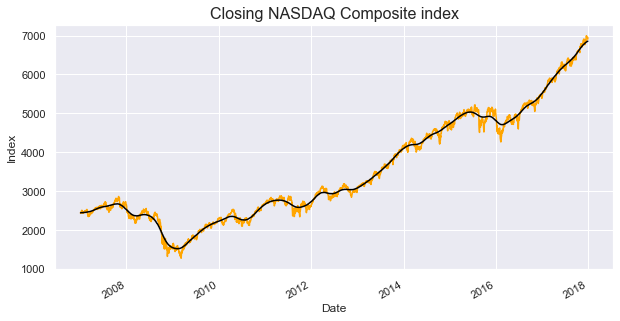

In [5]:
ax_nasdaq = df_nasdaq['close'].plot(color='orange')
df_nasdaq['close_filtered'].plot(ax = ax_nasdaq, color='black');
ax_nasdaq.set_title('Closing NASDAQ Composite index',fontsize=16);
ax_nasdaq.set_ylabel('Index')

## Rolling windows


In [6]:
df_nasdaq['median_filtered'] = df_nasdaq['close'].rolling(5).median()

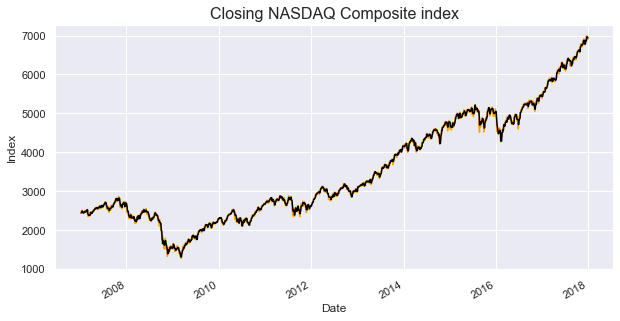

In [7]:
ax_nasdaq = df_nasdaq['close'].plot(color='orange')
df_nasdaq['median_filtered'].plot(ax=ax_nasdaq, color='black');
ax_nasdaq.set_title('Closing NASDAQ Composite index',fontsize=16);
ax_nasdaq.set_ylabel('Index');

## Filtering mouse trajectories


In [8]:
df_paths = pd.read_csv('../datasets/paths.csv', parse_dates=[0])

## Computing changes and finding maxima


In [9]:
df_nasdaq['close_diff'] = df_nasdaq['close'].diff()

In [10]:
date_min = df_nasdaq['close_diff'].idxmin()

In [11]:
df_nasdaq.loc[date_min, 'close_diff']

-202.06005900000036

In [12]:
date_max = df_nasdaq['close_diff'].idxmax()

In [13]:
df_nasdaq['close_diff_cumulative'] = df_nasdaq['close_diff'].cumsum()
df_nasdaq['change_since_beginning'] = df_nasdaq['close'] - df_nasdaq['close'].iloc[0]

In [14]:
df_nasdaq['abs_change'] = (df_nasdaq['close_diff']**2)**(1/2)
df_nasdaq['total_abs_change'] = df_nasdaq['abs_change'].cumsum()

## Approximating derivatives and finding trends


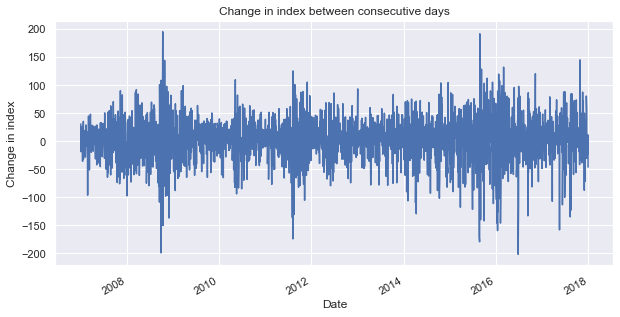

In [15]:
ax_marg = df_nasdaq['close_diff'].plot()
ax_marg.set_ylabel('Change in index')
ax_marg.set_title('Change in index between consecutive days');

In [16]:
df_nasdaq['close_filtered_deriv'] = gaussian_filter1d(df_nasdaq['close'], sigma=30, order=1, mode='nearest')

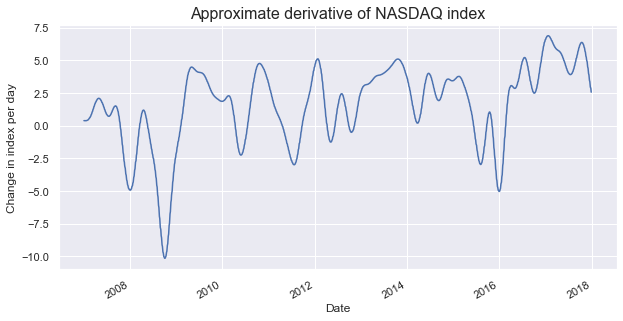

In [17]:
ax_deriv = df_nasdaq['close_filtered_deriv'].plot()
ax_deriv.set_title('Approximate derivative of NASDAQ index', fontsize=16);
ax_deriv.set_ylabel('Change in index per day');

# <span class="section">2.</span> Data aggregation


### Data: mouse trajectories


In [18]:
df_fitts = pd.read_csv('../datasets/fitts.csv')

### Multi-level indexing


In [19]:
df_fitts.set_index(['user','trial','t'], inplace=True)

### Data: user properties


In [20]:
df_user_props = pd.read_csv('../datasets/user_props.csv')

In [21]:
df_user_props.set_index('user',inplace = True)

### Conversion to readable table entries


In [22]:
dict_use_tue_laptop = {0 : False, 1 : True}
dict_right_handed = {0 : False, 1 : True}
dict_gender = {0 : 'Male', 1 : 'Female', 2 : 'Other'}

In [23]:
df_user_props['use_tue_laptop'] = df_user_props['use_tue_laptop'].astype(int)

#### The _Pandas_ function **`map()`**


In [24]:
df_user_props['use_tue_laptop'] = df_user_props['use_tue_laptop'].map(dict_use_tue_laptop)

### Data: user trial properties


In [25]:
dict_input_method = { 0 : 'trackpad', 1 : 'mouse' }

In [26]:
df_user_trial_props = pd.read_csv('../datasets/user_trial_props.csv')

In [27]:
df_speeds = df_fitts.groupby(['user','trial'])[['approximate_speed']].mean()

### Computing several aggregated quantities at once


In [28]:
df_features = df_fitts.groupby(['user','trial']).agg({'approximate_speed':['mean','median'], 'x':['max']})

In [29]:
df_features.columns=['appr_speed_mean', 'appr_speed_median', 'x_max']

### Joining two dataframes


In [30]:
df_fitts = pd.read_csv('../datasets/fitts.csv')
df_fitts.set_index(['user','trial'], inplace=True)
df_results = df_fitts.join(df_features)

# <span class="section">3.</span> Empirical cumulative distribution functions


In [31]:
df_experiment = pd.DataFrame([5,3,5,7,1], columns=['outcome']) 

In [32]:
df_experiment['outcome'].value_counts()

5    2
1    1
3    1
7    1
Name: outcome, dtype: int64

In [33]:
df_counts = pd.DataFrame( df_experiment['outcome'].value_counts().rename('counts') )

In [34]:
df_counts.sort_index(inplace=True)

In [35]:
df_counts['ecdf'] = df_counts['counts'].cumsum() / df_counts['counts'].sum()

(0.0, 10.0)

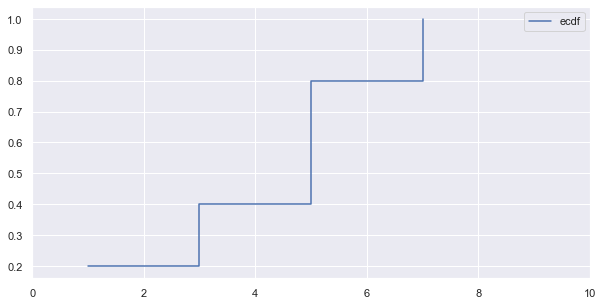

In [36]:
ax = df_counts[['ecdf']].plot(drawstyle='steps-post')
ax.set_xlim(0,10)

In [37]:
df_ecdf = df_counts[['ecdf']].copy()
df_ecdf.loc[-2000,'ecdf'] = 0
df_ecdf.loc[2000,'ecdf'] = 1
df_ecdf

,ecdf
1,0.2
3,0.4
5,0.8
7,1.0
-2000,0.0
2000,1.0


In [38]:
df_ecdf.sort_index(inplace=True)

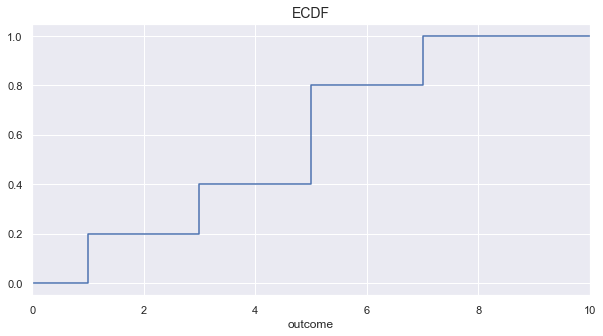

In [39]:
ax = df_ecdf['ecdf'].plot( drawstyle ='steps-post' )
ax.set_xlim(0, 10)
ax.set_xlabel('outcome')
ax.set_title('ECDF', fontsize=14);